# Programmazione di Applicazioni Data Intensive: Progetto 

- Candidato: Fabrizio Margotta
- Dataset: [Malicious and Benign Websites](https://www.kaggle.com/xwolf12/malicious-and-benign-websites) by Christian Urcuqui

## Introduzione

Il dataset scelto si concentra sulla **classificazione di siti malevoli**, tema rilevante nella cybersecurity poiché applicativi derivanti dall'analisi proposta possono permette di individuare host legati a nuove minacce sulla base dei risultati del modello di conoscenza.

Ciò può permettere di rafforzare i sistemi di difesa degli asset aziendali in quanto, ad esempio, si suppone di monitorare le comunicazioni Internet dei vari dispositivi, di fornire gli URL contattati al modello e di ricevere in risposta la classe. Di conseguenza un terzo sistema (ad esempio un firewall) può inserire i siti classificati in denylist oppure allowlist a seconda della classe identificata.

## Analisi esplorativa

### Import delle librerie

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set();
import sklearn

### Caricamento del dataset

Si procede con il caricamento del dataset, specificando variabili categoriche e variabili contenenti valori temporali:

In [116]:
dtypes = {
    'CHARSET': 'category',
    'SERVER': 'category',
    'WHOIS_COUNTRY': 'category',
    'WHOIS_STATEPRO': 'category',
}

In [117]:
import requests
import io

DS_URL = "https://gitlab.com/emrevoid/uni/dia/project/famar/-/raw/master/dataset.csv"

#https://stackoverflow.com/questions/51092889/receiving-http-error-403-forbidden-csv-download/51093473
response = requests.get(DS_URL)
file_object = io.StringIO(response.content.decode('utf-8'))

ds = pd.read_csv(file_object, header=0, index_col=0, sep=';', dtype=dtypes)

In [118]:
ds['WHOIS_REGDATE'] = pd.to_datetime(ds['WHOIS_REGDATE'], errors='coerce')
ds['WHOIS_UPDATED_DATE'] = pd.to_datetime(ds['WHOIS_UPDATED_DATE'], errors='coerce')
ds = ds.rename(columns={"Type": "malicious"})

In [119]:
ds.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,iso-8859-1,nginx,263.0,None,None,2015-10-10 18:21:00,NaT,7,0,2,700,9,10,1153,832,9,2.0,1
B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,NaT,NaT,17,7,4,1230,17,19,1265,1230,17,0.0,0
B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,NaT,NaT,0,0,0,0,0,0,0,0,0,0.0,0
B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,3812,39,37,18784,4380,39,8.0,0
B0_403,17,6,UTF-8,None,124140.0,US,TX,1996-12-05 00:00:00,2017-11-04 00:00:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


### Descrizione delle variabili

- **URL**: indice di ogni riga, corrisponde all'URL (anonimizzato) del sito
- **URL_LENGTH**: valore intero; numero di caratteri che compongono l'URL
- **NUMBER_SPECIAL_CHARACTERS**: valore intero; numero di caratteri speciali contenuti nell'URL (ad esempio `/`, `%`, `#`, `&`, `.`, `=`)
- **CHARSET**: valore categorico; standard per l'encoding dei caratteri (es. UTF-8, ISO-8859)
- **SERVER**: valore categorico; indica il software che il server utilizza per gestire le richieste (es. Apache, nginx)
- **CONTENT_LENGTH**: valore decimale; corrisponde all'header HTTP `Content-Length` che specifica la dimensione del contenuto (body) mandato al destinatario
- **WHOIS_COUNTRY**: valore categorico; Nazione di registrazione del dominio contattato (ottenuto tramite Whois)
- **WHOIS_STATEPRO**: valore categorico; Regione della nazione di registrazione del dominio contattato
- **WHOIS_REGDATE**: valore temporale; data e ora di registrazione del dominio
- **WHOIS_UPDATED_DATE**: valore temporale; data e ora di ultimo aggiornamento del server
- **TCP_CONVERSATION_EXCHANGE**: valore intero; numero dei pacchetti TCP scambiati con il server
- **DIST_REMOTE_TCP_PORT**: valore intero; numero di porte aperte nel server
- **REMOTE_IPS**: valore intero; numero di indirizzi IP contattati dal client
- **APP_BYTES**: valore intero; numero di byte totali trasferiti nella comunicazione
- **SOURCE_APP_PACKETS**: valore intero; numero di pacchetti inviati dal client al server
- **REMOTE_APP_PACKETS**: valore intero; numero di pacchetti ricevuti dal server
- **SOURCE_APP_BYTES**: valore intero; numero di byte inviati dal client al server
- **REMOTE_APP_BYTES**: valore intero; numero di byte ricevuti dal server
- **APP_PACKETS**: valore intero; numero di pacchetti totali trasferiti nella comunicazione
- **DNS_QUERY_TIMES**: valore decimale; numero di richieste DNS effettutate
- **malicious**: variabile categorica **da predire**; corrisponde alla classe dell'URL, indica se quest'ultimo è malevolo o meno

### Numero e distribuzione dei dati

Numero di istanze:

In [120]:
ds.shape[0]

1781

Numero di feature:

In [121]:
ds.shape[1]

20

Distribuzione della variabile di classificazione:

In [122]:
ds["malicious"].value_counts()

0    1565
1     216
Name: malicious, dtype: int64

In [123]:
ds["malicious"].value_counts(normalize=True)

0    0.87872
1    0.12128
Name: malicious, dtype: float64

Possiamo notare che le classi sono sbilanciate, i siti malevoli sono il 12% del totale, si procederà dunque in seguito ad un resampling delle classi per bilanciarne la distribuzione.

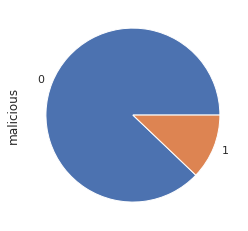

In [124]:
ds["malicious"].value_counts().plot.pie();

Osserviamo la distribuzione dei dati in termine di medie, deviazione standard, minimi/massimi e percentili:

In [125]:
ds.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


### Primo raffinamento del dataset

- osserviamo che per i server vengono memorizzati nome e versione nella stessa stringa: si procede dunque ad ignorare la versione, considendo soltanto il nome del software utilizzato
- i charset presentano distinzioni tra maiuscole e minuscole, si procede dunque a sostituirli con un unico valore
- la stessa correzione viene operata per il campo `WHOIS_COUNTRY`

In [126]:
ds['SERVER'].value_counts()[:20]

Apache                                                                                       386
nginx                                                                                        211
None                                                                                         175
Microsoft-HTTPAPI/2.0                                                                        113
cloudflare-nginx                                                                              94
Microsoft-IIS/7.5                                                                             51
GSE                                                                                           49
Server                                                                                        49
YouTubeFrontEnd                                                                               42
nginx/1.12.0                                                                                  36
ATS                           

In [127]:
ds['SERVER'] = np.where(ds['SERVER'].str.contains('Apache/'), 'Apache', ds['SERVER'])
ds['SERVER'] = np.where(ds['SERVER'].str.contains('nginx/'), 'nginx', ds['SERVER'])
ds['SERVER'] = np.where(ds['SERVER'].str.contains('Microsoft-'), 'Microsoft', ds['SERVER'])

In [128]:
ds['CHARSET'].unique()
ds['CHARSET']=np.where(ds['CHARSET'] == 'iso-8859-1', 'ISO-8859-1', ds['CHARSET'])
ds['CHARSET']=np.where(ds['CHARSET'] == 'ISO-8859', 'ISO-8859-1', ds['CHARSET'])
ds['CHARSET']=np.where(ds['CHARSET'] == 'utf-8', 'UTF-8', ds['CHARSET'])

In [129]:
ds['WHOIS_COUNTRY'].unique()
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'United Kingdom', 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == "[u'GB', u'UK']", 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'United Kingdom', 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'us', 'US', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'se', 'SE', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'ru', 'RU', ds['WHOIS_COUNTRY'])

### Numero di valori distinti delle feature

In [130]:
ds.nunique()

URL_LENGTH                   142
NUMBER_SPECIAL_CHARACTERS     31
CHARSET                        6
SERVER                       114
CONTENT_LENGTH               637
WHOIS_COUNTRY                 44
WHOIS_STATEPRO               182
WHOIS_REGDATE                888
WHOIS_UPDATED_DATE           593
TCP_CONVERSATION_EXCHANGE    103
DIST_REMOTE_TCP_PORT          66
REMOTE_IPS                    18
APP_BYTES                    825
SOURCE_APP_PACKETS           113
REMOTE_APP_PACKETS           116
SOURCE_APP_BYTES             885
REMOTE_APP_BYTES             822
APP_PACKETS                  113
DNS_QUERY_TIMES               10
malicious                      2
dtype: int64

### Gestione di valori nulli

Verifichiamo che nel dataset siano presenti valori nulli:

In [131]:
pd.set_option('display.max_rows', None)
ds.isna().sum()

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         0
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                130
WHOIS_UPDATED_DATE           139
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
malicious                      0
dtype: int64

Usiamo il metodo `.fillna()`:
- per le feature numeriche sostituiamo i valori nulli con le medie

In [132]:
ds['CONTENT_LENGTH'].fillna(ds['CONTENT_LENGTH'].mean(), inplace=True)
ds['DNS_QUERY_TIMES'].fillna(ds['DNS_QUERY_TIMES'].mean(), inplace=True)

- per le feature temporali (`WHOIS_REGDATE` e `WHOIS_UPDATED_DATE`) usiamo i parametri `ffill` o `bfill`

In [133]:
ds['WHOIS_REGDATE'].fillna(method="ffill", inplace=True)
ds['WHOIS_UPDATED_DATE'].fillna(method="ffill", inplace=True)
ds['WHOIS_UPDATED_DATE'].fillna(method="bfill", inplace=True)

Verifichiamo che il problema dei valori nulli è stato risolto:

In [134]:
ds.isna().sum()

URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
malicious                    0
dtype: int64

### Correlazione tra le feature

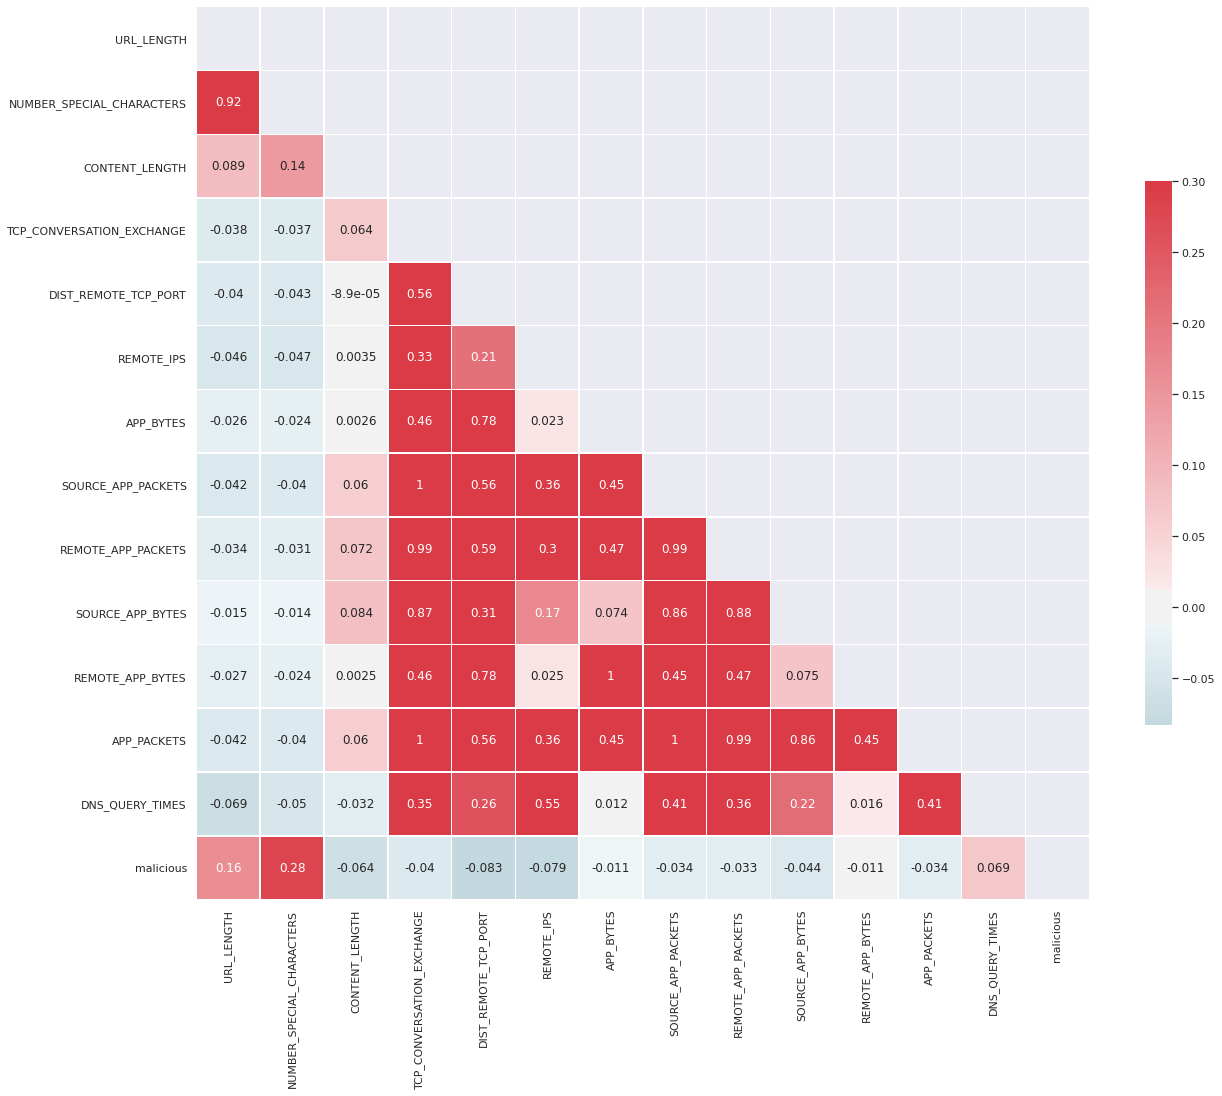

In [135]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = ds.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

Il grafico mostra la correlazione tra le feature su cui è possibile fare una prima analisi:

- innanzitutto la classe `malicious` sembra essere influenzata dal numero di caratteri speciali nell'URL e dalla lunghezza dell'URL stesso, e ciò è plausibile poiché tipicamente gli URL vengono randomizzati o offuscati
- il numero di caratteri dell'URL è correlato al numero di caratteri speciali dell'URL
- il numero di pacchetti (al livello applicativo) mandati dal client al server (`SOURCE_APP_PACKETS`) e il numero di pacchetti TCP scambiati durante la conversazione tra i due nodi (`TCP_CONVERSATION_EXCHANGE`) sono chiaramente correlati se assumiamo che gli applicativi (ad esempio un client e server web) hanno scambiato dati basandosi su canali di comunicazione TCP (ad esempio pagine web mediante HTTP)
  - allo stesso modo per le feature `REMOTE_APP_BYTES`, `APP_BYTES` (quindi il numero di byte totali trasferiti) e `APP_PACKETS` (il numero totale di pacchetti IP scambiati)

### Grafici a dispersione

#### Rimozione outliers

Rimozione di valori fuori scala che non permettono di visualizzare correttamente alcuni grafici a dispersione (poiché "appiattiscono" la distribuzione dei dati).

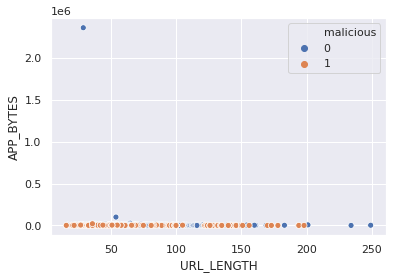

In [136]:
ds_ordered = ds.sort_values('malicious')
ax = sns.scatterplot(x="URL_LENGTH", y="APP_BYTES", hue="malicious", data=ds_ordered)

In [137]:
pd.set_option('display.max_rows', 20)
ds = ds.drop(ds.index[ds.APP_BYTES > 40000])
ds.sort_values('APP_BYTES')['APP_BYTES']

URL
B0_896         0
B0_863         0
B0_976         0
B0_980         0
B0_1291        0
           ...  
B0_304     18084
M0_121     20074
B0_737     20749
B0_222     23383
B0_481     26631
Name: APP_BYTES, Length: 1779, dtype: int64

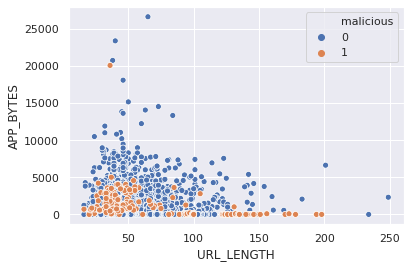

In [138]:
ds_ordered = ds.sort_values('malicious')
ax = sns.scatterplot(x="URL_LENGTH", y="APP_BYTES", hue="malicious", data=ds_ordered)

In [140]:
ds = ds.drop(ds.index[ds.CONTENT_LENGTH > 200000])

In [141]:
ds = ds.drop(ds.index[ds.DNS_QUERY_TIMES >= 20])

#### Grafici a dispersione su coppie di variabili

Grazie alla libreria [seaborn](https://seaborn.pydata.org/) è possibile generare grafici a dispersione tra tutte le coppie di variabili del dataset (o un loro sottoinsieme).

In [142]:
features = ['URL_LENGTH',
            'NUMBER_SPECIAL_CHARACTERS',
            'APP_BYTES',
            'CONTENT_LENGTH',
            'TCP_CONVERSATION_EXCHANGE',
            'SOURCE_APP_PACKETS',
            'REMOTE_APP_PACKETS',
            'DNS_QUERY_TIMES']

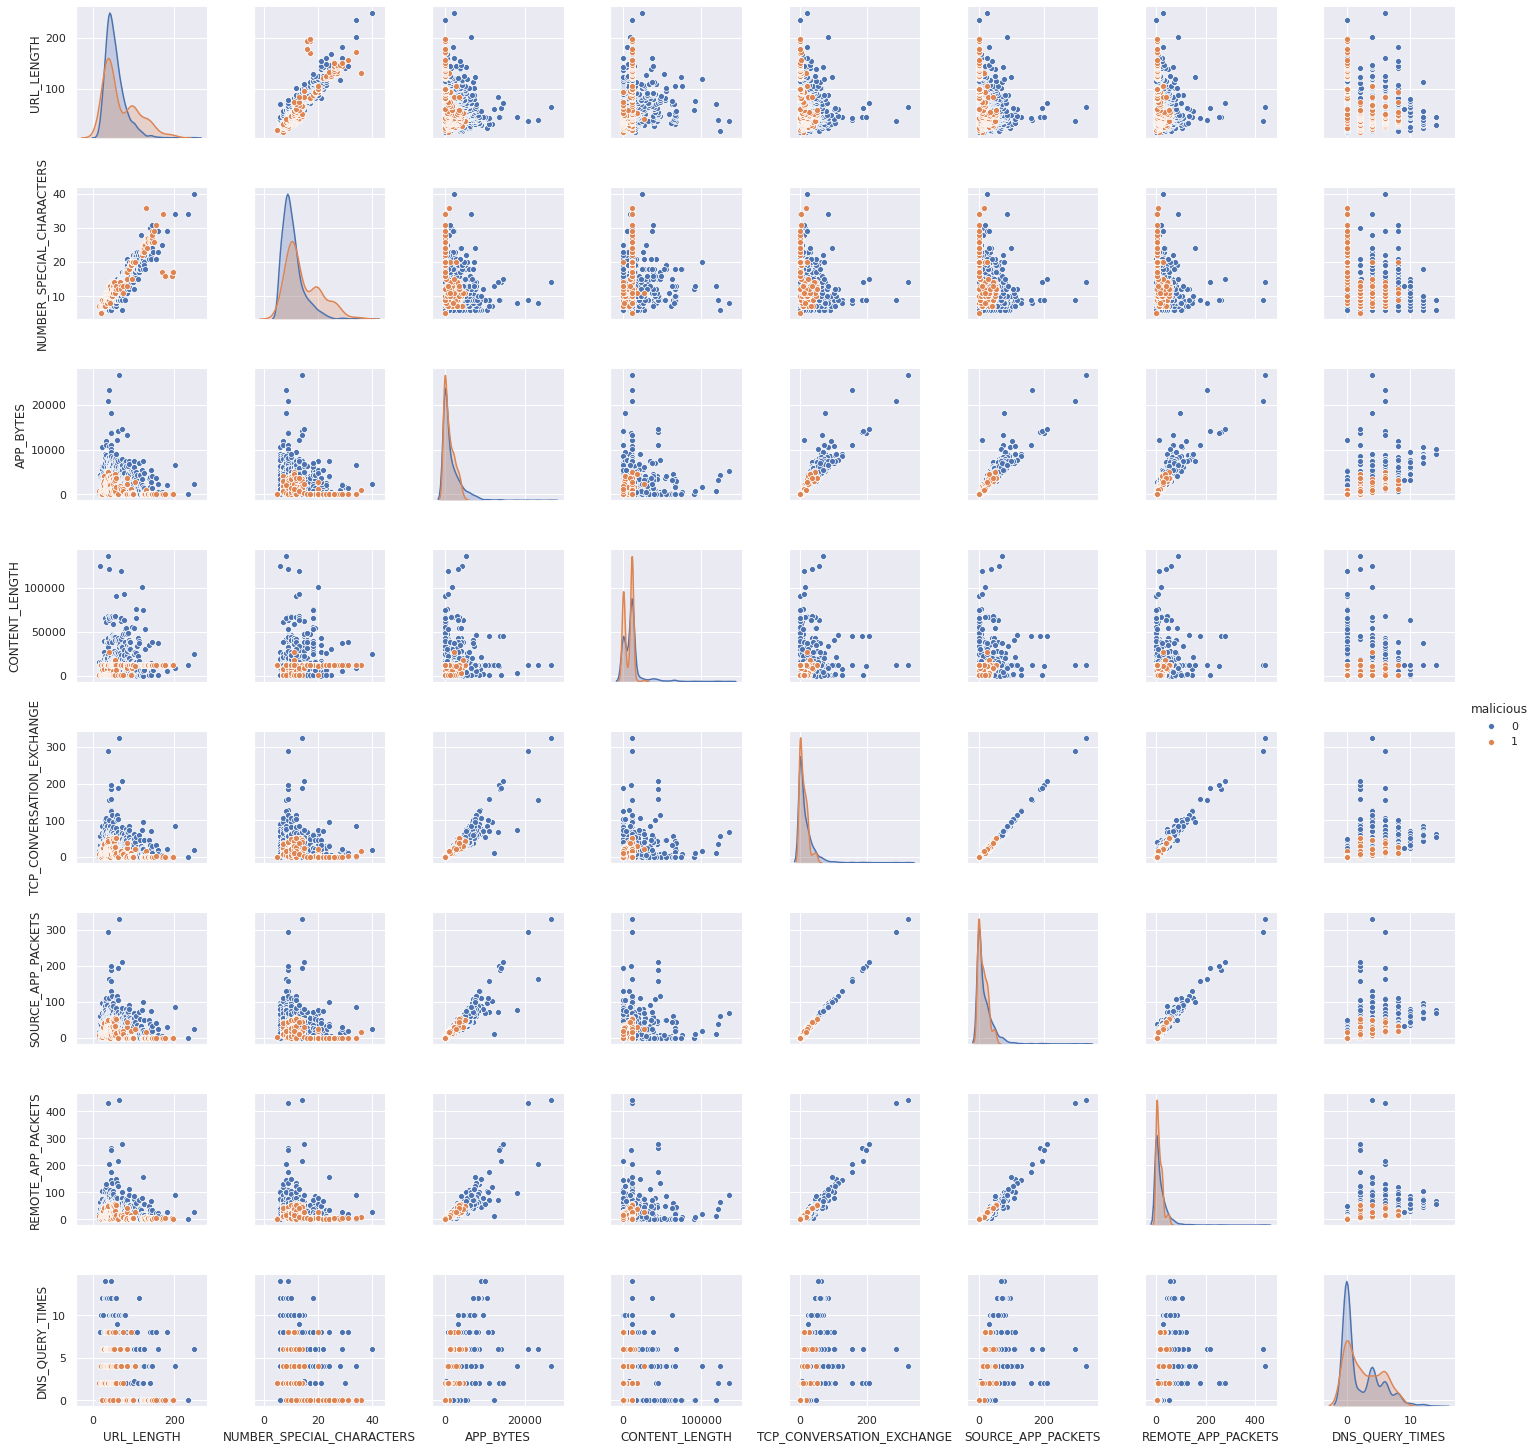

In [143]:
sns.set();
sns.pairplot(data=ds, hue="malicious", vars=features);

I grafici in diagonale mostrano la distribuzione dei dati rispetto alla feature in oggetto, da cui possiamo osservare che i siti malevoli hanno URL più lunghi e con più caratteri speciali rispetto ai siti non malevoli.

Gli altri grafici a dispersione mostrano che sono possibili diverse classificazioni lineari tra le feature, mentre altre (soprattutto quelle in cui è presente la colonna `DNS_QUERY_TIMES`) possono richiedere sforzi ulteriori, come classificazioni non lineari.

## Preparazione del dataset

### Binarizzazione delle variabili categoriche

In [28]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['SERVER'].value_counts()

malicious  SERVER                                                         
0          Apache                                                             500
           nginx                                                              271
           Microsoft                                                          182
           None                                                               175
           cloudflare-nginx                                                    87
           GSE                                                                 49
           Server                                                              49
           YouTubeFrontEnd                                                     42
           ATS                                                                 30
           Apache-Coyote/1.1                                                   20
           Varnish                                                              7
           LiteSpeed   

In [29]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['CHARSET'].value_counts()

malicious  CHARSET     
0          UTF-8           902
           ISO-8859-1      503
           us-ascii        151
           None              6
           windows-1252      1
1          UTF-8           152
           ISO-8859-1       58
           us-ascii          4
           None              1
           windows-1251      1
Name: CHARSET, dtype: int64

#### SERVER

Si prendono in considerazione i tre web server più frequenti nel dataset:

In [30]:
ds['SERVER'].value_counts()[:3]

Apache       622
nginx        337
Microsoft    198
Name: SERVER, dtype: int64

Di seguito si confrontano il numero e la distribuzione (in base alla classe) dei dati che verranno rimossi rispetto a quelli mantenuti nel dataset.

In [31]:
unpopular_servers = ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)]
unpopular_servers['malicious'].value_counts()

0    610
1     12
Name: malicious, dtype: int64

In [144]:
unpopular_servers.shape[0]

622

In [33]:
popular_servers = ds[ds['SERVER'].isin(ds.SERVER.value_counts()[:3].index)]
popular_servers['malicious'].value_counts()

0    953
1    204
Name: malicious, dtype: int64

In [145]:
popular_servers.shape[0]

1157

In [35]:
ds = ds.drop(ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)].index)

In [36]:
ds['malicious'].value_counts()

0    953
1    204
Name: malicious, dtype: int64

In [37]:
dtype_categories = ['SERVER']
ds = pd.get_dummies(ds, columns=dtype_categories, prefix=dtype_categories)

#### CHARSET

In [38]:
ds['CHARSET'].value_counts()[:3]

UTF-8         622
ISO-8859-1    398
us-ascii      132
Name: CHARSET, dtype: int64

In [39]:
unpopular_charsets = ds[ds['CHARSET'].isin(ds.CHARSET.value_counts()[3:].index)]
unpopular_charsets['malicious'].value_counts()

0    3
1    2
Name: malicious, dtype: int64

In [40]:
popular_charsets = ds[ds['CHARSET'].isin(ds.CHARSET.value_counts()[:3].index)]
popular_charsets['malicious'].value_counts()

0    950
1    202
Name: malicious, dtype: int64

In [41]:
ds = ds.drop(ds[ds['CHARSET'].isin(ds.CHARSET.value_counts()[3:].index)].index)

In [42]:
dtype_categ_charset = ['CHARSET']
ds = pd.get_dummies(ds, columns=dtype_categ_charset, prefix=dtype_categ_charset)

In [43]:
ds.head(5)

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,...,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious,SERVER_Apache,SERVER_Microsoft,SERVER_nginx,CHARSET_ISO-8859-1,CHARSET_UTF-8,CHARSET_us-ascii
URL,,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,263.000000,None,None,2015-10-10 18:21:00,2013-12-09 00:45:00,7,0,2,...,832,9,2.0,1,0,0,1,1,0,0
B0_2314,16,6,15087.000000,None,None,2015-10-10 18:21:00,2013-12-09 00:45:00,17,7,4,...,1230,17,0.0,0,1,0,0,0,1,0
B0_911,16,6,324.000000,None,None,2015-10-10 18:21:00,2013-12-09 00:45:00,0,0,0,...,0,0,0.0,0,0,1,0,0,0,1
B0_113,17,6,162.000000,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,...,4380,39,8.0,0,0,0,1,1,0,0
B0_2064,18,7,11726.927761,SC,Mahe,2016-03-08 14:30:00,2016-03-10 03:45:00,11,6,9,...,894,11,0.0,0,0,0,1,0,1,0


### Divisione in X e y

In [44]:
X = ds.drop(['WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'malicious'], axis=1)
y = ds['malicious']

### Risoluzione problema classi sbilanciate

Si osserva nuovamente la distribuzione della classe sui dati:

In [45]:
ds.shape

(1152, 24)

In [46]:
ds["malicious"].value_counts()

0    950
1    202
Name: malicious, dtype: int64

In [47]:
ds["malicious"].value_counts(normalize=True)

0    0.824653
1    0.175347
Name: malicious, dtype: float64

Per risolvere lo sbilanciamento delle classi si fa uso del metodo SMOTE implementato nella libreria [`imblearn`](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html).

In [48]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [49]:
ds_oversampled = pd.concat([X_resampled, y_resampled], axis=1)

Si osserva che il numero di elementi del dataset non è cambiato, tuttavia ora le classi sono bilanciate al 50%.

In [50]:
ds.shape

(1152, 24)

In [51]:
ds_oversampled["malicious"].value_counts()

1    950
0    950
Name: malicious, dtype: int64

In [52]:
ds_oversampled["malicious"].value_counts(normalize=True)

1    0.5
0    0.5
Name: malicious, dtype: float64

Seguono i grafici a dispersione sulle variabili `URL_LENGTH` e `NUMBER_SPECIAL_CHARACTERS` del dataset sbilanciato e quello risultante dall'operazione di bilanciamento, utili a notare visivamente la differenza nella distribuzione dei dati.

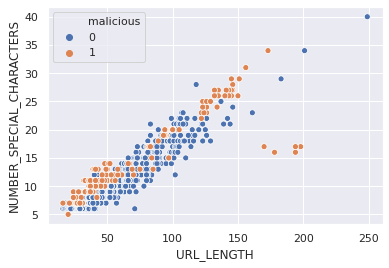

In [53]:
ds_ordered = ds.sort_values('malicious')
ax = sns.scatterplot(x="URL_LENGTH", y="NUMBER_SPECIAL_CHARACTERS", hue="malicious", data=ds_ordered)

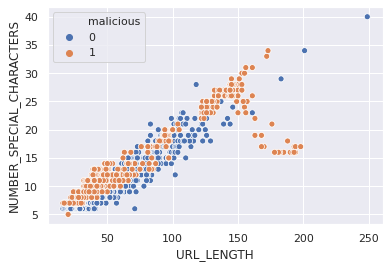

In [54]:
ds_oversampled_ordered = ds_oversampled.sort_values('malicious')
ax = sns.scatterplot(x="URL_LENGTH", y="NUMBER_SPECIAL_CHARACTERS", hue="malicious", data=ds_oversampled_ordered)

## Classificazione

Separazione del dataset in training e test set:

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=1/3,
    random_state=42,
)

Stratified K fold: preparazione dell'oggetto:

In [56]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    214
1    208
Name: malicious, dtype: int64
0    214
1    208
Name: malicious, dtype: int64
0    214
1    208
Name: malicious, dtype: int64


### Perceptron

Perceptron in pipeline con grid search su Standardizzazione, feature polinomiali e regolarizzazione con coefficiente a 5 valori nell'intervallo $10^{-2}$, $10^2$.

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import GridSearchCV

In [58]:
scale = [None, StandardScaler()]
polynomial = [PolynomialFeatures(include_bias=False)]
grid = [
    {
        "std" : scale,
        "perceptron__penalty": ["l2", "l1", "elasticnet"],
        "perceptron__alpha": np.logspace(-2, 2, 5)
    },
]

model_perceptron = Pipeline([
    ('std', None),
    ('poly', PolynomialFeatures()),
    ('perceptron', Perceptron(random_state=42))
])

gs_perceptron = GridSearchCV(model_perceptron, grid, cv=skf)
gs_perceptron.fit(X_train, y_train);

In [59]:
print('Accuracy on train {:.2f}%'.format(gs_perceptron.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_perceptron.score(X_val, y_val)*100))
print(gs_perceptron.best_params_)

Accuracy on train 71.41%
Accuracy on val 71.92%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l2', 'std': StandardScaler()}


Grazie all'utilizzo della regolarizzazione è possibile osservare quali feature hanno influenzato di più l'accuratezza del modello:

In [60]:
pd.Series(gs_perceptron.best_estimator_[2].coef_[0],
          index=gs_perceptron.best_estimator_[1].get_feature_names(X_train.columns)).sort_values(ascending=False)

CHARSET_ISO-8859-1 CHARSET_UTF-8                       5.998145
REMOTE_IPS SERVER_Microsoft                            3.967910
SERVER_Apache SERVER_Microsoft                         3.716360
DNS_QUERY_TIMES                                        3.174444
CONTENT_LENGTH CHARSET_ISO-8859-1                      2.611112
CHARSET_UTF-8 CHARSET_us-ascii                         2.339172
SERVER_Apache CHARSET_ISO-8859-1                       2.256542
REMOTE_APP_PACKETS SERVER_Microsoft                    2.216965
NUMBER_SPECIAL_CHARACTERS CHARSET_UTF-8                2.188284
SERVER_Microsoft SERVER_nginx                          2.176654
REMOTE_IPS DNS_QUERY_TIMES                             2.102028
REMOTE_APP_BYTES SERVER_Microsoft                      2.091182
APP_BYTES SERVER_Microsoft                             2.083584
APP_PACKETS SERVER_Microsoft                           2.038518
SOURCE_APP_PACKETS SERVER_Microsoft                    2.038518
TCP_CONVERSATION_EXCHANGE SERVER_Microso

Addestriamo lo stesso modello sui DataFrame contenenti le classi sbilanciate:

In [61]:
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42,
)

In [62]:
# Perceptron with standard scaler
model_perceptron_unb = Pipeline([
    ('std', None),
    ("poly", PolynomialFeatures()),
    ('perceptron', Perceptron(random_state=42))
])

gs_perceptron_unb = GridSearchCV(model_perceptron_unb, grid, cv=skf)
gs_perceptron_unb.fit(X_train_unb, y_train_unb);

In [63]:
print('Accuracy on train {:.2f}%'.format(gs_perceptron_unb.score(X_train_unb, y_train_unb)*100))
print('Accuracy on val {:.2f}%'.format(gs_perceptron_unb.score(X_val_unb, y_val_unb)*100))
print(gs_perceptron_unb.best_params_)

Accuracy on train 80.34%
Accuracy on val 82.81%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l2', 'std': None}


#### Matrice di confusione

Calcoliamo la matrice di confusione sia per il DataSet originale con classi sbilanciate che con quello in cui le classi sono state bilanciate mediante SMOTE.

In [64]:
def compute_confusion_matrix(model, X_val, y_val):
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_val)
    return confusion_matrix(y_val, y_pred)

In [65]:
# https://www.kaggle.com/agungor2/various-confusion-matrix-plots#1.-Seaborn-Heatmap-
def plot_confusion_matrix(model, X_val, y_val, y_train, label_X='Actual', label_y='Predicted'):
    cm = compute_confusion_matrix(model, X_val, y_val)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
    df_cm.index.name = label_X
    df_cm.columns.name = label_y
    plt.figure(figsize = (4,3));
    sns.set(font_scale=1.4); #for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

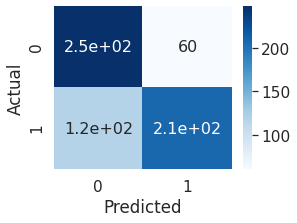

In [66]:
plot_confusion_matrix(gs_perceptron, X_val, y_val, y_train)

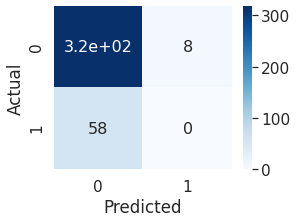

In [67]:
plot_confusion_matrix(gs_perceptron_unb, X_val_unb, y_val_unb, y_train_unb)

#### Precision e recall

In [68]:
from sklearn.metrics import classification_report

Balanced:

In [69]:
y_pred = gs_perceptron.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       308
           1       0.78      0.64      0.70       326

    accuracy                           0.72       634
   macro avg       0.73      0.72      0.72       634
weighted avg       0.73      0.72      0.72       634



Unbalanced:

In [70]:
y_pred_unb = gs_perceptron.predict(X_val_unb)
print(classification_report(y_val_unb, y_pred_unb))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       326
           1       0.27      0.47      0.34        58

    accuracy                           0.73       384
   macro avg       0.58      0.62      0.59       384
weighted avg       0.80      0.73      0.76       384



#### Intervallo di confidenza

In [71]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [72]:
def model_conf_interval(model, X, y, level=0.95):
    from scipy.stats import norm
    a = model.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2) # = (1 + 1 - a)/2 = (2 - a)/2 = 1 - a/2
    return conf_interval(a, N, Z)

In [73]:
model_conf_interval(gs_perceptron, X_val, y_val)

(0.6830240557731049, 0.7528209275774516)

In [74]:
model_conf_interval(gs_perceptron_unb, X_val, y_val)

(0.43616187576413884, 0.5136689175192503)

### Regressione logistica

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [76]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "logreg__penalty": ["l1"],
        "logreg__C": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_logreg = Pipeline([
    ('std', None),
    ('logreg', LogisticRegression(solver="saga", dual=False, random_state=42, max_iter=10000))
])

gs_logreg = GridSearchCV(model_logreg, grid, cv=skf)
gs_logreg.fit(X_train, y_train);

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std', None),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'logreg__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'logreg__penalty': ['l1'],
                          'std': [None, StandardScaler()]}])

In [77]:
print('Accuracy on train {:.2f}%'.format(gs_logreg.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_logreg.score(X_val, y_val)*100))
print(gs_logreg.best_params_)

Accuracy on train 89.10%
Accuracy on val 90.54%
{'logreg__C': 1.0, 'logreg__penalty': 'l1', 'std': StandardScaler()}


In [78]:
pd.Series(gs_logreg.best_estimator_[1].coef_[0], index=X_train.columns).sort_values(ascending=False)

REMOTE_APP_PACKETS           3.746998
NUMBER_SPECIAL_CHARACTERS    1.645013
DNS_QUERY_TIMES              0.550390
SOURCE_APP_PACKETS           0.282788
APP_PACKETS                  0.282788
TCP_CONVERSATION_EXCHANGE    0.254597
REMOTE_APP_BYTES            -0.084231
APP_BYTES                   -0.124567
URL_LENGTH                  -0.405532
REMOTE_IPS                  -1.166910
SERVER_Microsoft            -1.506741
CHARSET_us-ascii            -1.613577
CHARSET_UTF-8               -1.627649
SERVER_nginx                -1.985923
CHARSET_ISO-8859-1          -2.029029
CONTENT_LENGTH              -2.047741
SERVER_Apache               -2.220881
SOURCE_APP_BYTES            -4.720056
DIST_REMOTE_TCP_PORT        -4.845577
dtype: float64

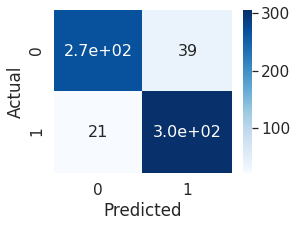

In [80]:
plot_confusion_matrix(gs_logreg, X_val, y_val, y_train)

In [79]:
y_pred_logreg = gs_logreg.predict(X_val)
print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       308
           1       0.89      0.94      0.91       326

    accuracy                           0.91       634
   macro avg       0.91      0.90      0.91       634
weighted avg       0.91      0.91      0.91       634



In [81]:
model_conf_interval(gs_logreg, X_val, y_val)

(0.8800745175189826, 0.9257683653665782)

### SVM

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [83]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "svm__C": np.logspace(-3, 3, 5)
    },
]

# Perceptron with standard scaler
model_svm = Pipeline([
    ('std', None),
    ('svm', SVC())
])

gs_svm = GridSearchCV(model_svm, grid, cv=skf)
gs_svm.fit(X_train, y_train);

In [84]:
print('Accuracy on train {:.2f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_svm.score(X_val, y_val)*100))
print(gs_svm.best_params_)

Accuracy on train 97.00%
Accuracy on val 97.16%
{'std': StandardScaler(), 'svm__C': 31.622776601683793}


In [85]:
pd.Series(gs_svm.best_estimator_[1].support_vectors_[0], index=X_train.columns).sort_values(ascending=False)

DNS_QUERY_TIMES              2.082685
SERVER_nginx                 1.650312
REMOTE_APP_BYTES             1.609110
REMOTE_IPS                   1.549565
APP_BYTES                    1.519113
APP_PACKETS                  1.188043
SOURCE_APP_PACKETS           1.188043
DIST_REMOTE_TCP_PORT         1.101778
TCP_CONVERSATION_EXCHANGE    1.013254
CHARSET_UTF-8                0.851349
REMOTE_APP_PACKETS           0.483442
NUMBER_SPECIAL_CHARACTERS    0.254820
URL_LENGTH                   0.221652
SOURCE_APP_BYTES             0.033764
CHARSET_us-ascii            -0.278293
SERVER_Microsoft            -0.368003
CONTENT_LENGTH              -0.512533
CHARSET_ISO-8859-1          -0.620581
SERVER_Apache               -1.065320
dtype: float64

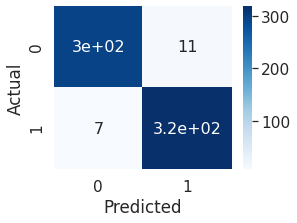

In [86]:
plot_confusion_matrix(gs_svm, X_val, y_val, y_train)

In [87]:
y_pred_svm = gs_svm.predict(X_val)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       308
           1       0.97      0.98      0.97       326

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



In [88]:
model_conf_interval(gs_svm, X_val, y_val)

(0.9555699950124925, 0.9819670555041717)

### Modello casuale

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [151]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
    },
]

# Perceptron with standard scaler
model_random = Pipeline([
    ('std', None),
    ('rnd', DummyClassifier(strategy='uniform', random_state=42))
], )

gs_random = GridSearchCV(model_random, grid, cv=skf)
gs_random.fit(X_train, y_train);

In [155]:
print('Accuracy on train {:.2f}%'.format(gs_random.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_random.score(X_val, y_val)*100))
print(gs_random.best_params_)

Accuracy on train 50.95%
Accuracy on val 53.47%
{'std': None}


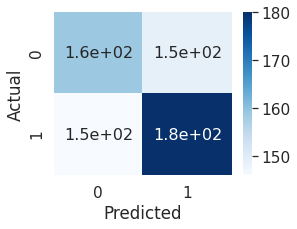

In [152]:
plot_confusion_matrix(gs_random, X_val, y_val, y_train)

In [156]:
y_pred_random = gs_random.predict(X_val)
print(classification_report(y_val, y_pred_random))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       308
           1       0.55      0.55      0.55       326

    accuracy                           0.53       634
   macro avg       0.53      0.53      0.53       634
weighted avg       0.53      0.53      0.53       634



In [157]:
model_conf_interval(gs_random, X_val, y_val)

(0.49578164371991157, 0.5732010155154282)

## Confronto tra i modelli

In [89]:
def diff_interval(a1, a2, N1, N2, Z):
    sigma1 = a1 * (1 - a1) / N1
    sigma2 = a2 * (1 - a2) / N2
    sigma = np.sqrt(sigma1 + sigma2)
    diff = abs(a1 - a2)
    Z_sigma = Z * sigma
    return (diff - Z_sigma, diff + Z_sigma)

In [90]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    from scipy.stats import norm
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N1 = len(X)
    N2 = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N1, N2, Z)

In [91]:
model_diff_interval(gs_perceptron, gs_perceptron_unb, X_val, y_val)

(0.19218764094669238, 0.2967713495895852)

In [92]:
model_diff_interval(gs_perceptron, gs_logreg, X_val, y_val)

(0.1443745198175852, 0.22786522781648433)

In [93]:
model_diff_interval(gs_perceptron, gs_svm, X_val, y_val)

(0.2150742878941797, 0.28965757330455844)

In [94]:
model_diff_interval(gs_logreg, gs_svm, X_val, y_val)

(0.04004894033870232, 0.09244317322596629)